# Use examples of [edges](https://github.com/romainsacchi/edges)

Author: [romainsacchi](https://github.com/romainsacchi)

This notebook shows examples on how to use `edge` to use exchange-specific
characterization factors in the characterization matrix of `bw2calc`, combining the use of exchange names and locations.

## Requirements

* **Pyhton 3.10 or higher (up to 3.11) is highly recommended**

# Use case with [brightway2](https://brightway.dev/)

`brightway2` is an open source LCA framework for Python.
To use `premise` from `brightway2`, it requires that you have an activated `brightway2` project with a `biosphere3` database as well as an [ecoinvent](https://ecoinvent.prg) v.3 cut-off or consequential database registered in that project. Please refer to the brightway [documentation](https://brightway.dev) if you do not know how to create a project and install ecoinvent.


# 📊 Supported Uncertainty Distributions in `edges`

The `sample_cf_distribution` function supports several uncertainty distributions used to model variability in characterization factors (CFs). Each distribution type requires specific parameters inside the `uncertainty` dictionary.

## 📌 General Structure

```json
"uncertainty": {
  "distribution": "<distribution_name>",
  "parameters": { ... },
  "negative": 0 | 1  // Optional: If 1, sampled values are negated
}
```

---

## 🎲 Available Distributions and Parameters

### 1. `uniform`

Samples uniformly between `minimum` and `maximum`.

```json
{
  "distribution": "uniform",
  "parameters": {
    "minimum": 0.5,
    "maximum": 1.5
  }
}
```

---

### 2. `triang`

Triangular distribution with:
- `minimum`: lower bound,
- `maximum`: upper bound,
- `loc`: mode (peak value).

```json
{
  "distribution": "triang",
  "parameters": {
    "minimum": 0.5,
    "loc": 1.0,
    "maximum": 2.0
  }
}
```

---

### 3. `normal`

Normal distribution with:
- `loc`: mean,
- `scale`: standard deviation,
- `minimum`, `maximum`: clipping bounds.

```json
{
  "distribution": "normal",
  "parameters": {
    "loc": 1.0,
    "scale": 0.2,
    "minimum": 0.5,
    "maximum": 1.5
  }
}
```

---

### 4. `lognorm`

Log-normal distribution:
- `shape_a`: shape parameter,
- `loc`, `scale`: location and scale,
- `minimum`, `maximum`: clipping bounds.

```json
{
  "distribution": "lognorm",
  "parameters": {
    "shape_a": 0.5,
    "loc": 0.0,
    "scale": 1.0,
    "minimum": 0.2,
    "maximum": 5.0
  }
}
```

---

### 5. `beta`

Beta distribution scaled to a range:
- `shape_a`, `shape_b`: shape parameters,
- `loc`: lower bound,
- `scale`: range width,
- `minimum`, `maximum`: clipping bounds.

```json
{
  "distribution": "beta",
  "parameters": {
    "shape_a": 2,
    "shape_b": 5,
    "loc": 1.0,
    "scale": 2.0,
    "minimum": 1.0,
    "maximum": 3.0
  }
}
```

---

### 6. `gamma`

Gamma distribution:
- `shape_a`: shape parameter,
- `scale`: scale,
- `loc`: location offset,
- `minimum`, `maximum`: clipping bounds.

```json
{
  "distribution": "gamma",
  "parameters": {
    "shape_a": 2.0,
    "scale": 100.0,
    "loc": 50.0,
    "minimum": 50.0,
    "maximum": 300.0
  }
}
```

---

### 7. `weibull_min`

Weibull minimum distribution:
- `shape_a`: shape parameter,
- `scale`, `loc`: scale and offset,
- `minimum`, `maximum`: clipping bounds.

```json
{
  "distribution": "weibull_min",
  "parameters": {
    "shape_a": 1.5,
    "scale": 100.0,
    "loc": 900.0,
    "minimum": 900.0,
    "maximum": 1300.0
  }
}
```

---

### 8. `discrete_empirical`

Discrete probability distribution over a list of values. Each value may be:
- A **number**, or
- A **nested distribution** (e.g., a `normal`, `triang`, etc.).

```json
{
  "distribution": "discrete_empirical",
  "parameters": {
    "values": [
      0.9,
      {
        "distribution": "normal",
        "parameters": {
          "loc": 1.1,
          "scale": 0.1,
          "minimum": 1.0,
          "maximum": 1.2
        }
      }
    ],
    "weights": [0.25, 0.75]
  }
}
```

---

## ⚠️ Notes

- If `use_distributions=False` or `uncertainty` is missing, the constant `value` is used.
- If `"negative": 1` is set, sampled values are negated.
- Nested distributions in `discrete_empirical` are supported recursively.

---


We will be using a simple example contained in `lcia_example_5.json` which looks like this:

## Example 1

In [ ]:
{
    "name": "Some GWP with uncertainty",
    "unit": "kg CO2-eq.",
    "versions": "1.0",
    "exchanges": [
    {
        "supplier": {
            "name": "Carbon dioxide, fossil",
            "matrix": "biosphere"
        },
        "consumer": {"matrix": "technosphere"},
        "value": 1.0,
        "uncertainty": {
            "distribution": "uniform",
            "parameters": {"minimum": 0.8, "maximum": 1.2}
        }
    },
    {
        "supplier": {
            "name": "Methane, fossil"
            , "matrix": "biosphere"
        },
        "consumer": {"matrix": "technosphere"},
        "value": 25.0,
        "uncertainty": {
            "distribution": "triang",
            "parameters": {"minimum": 23.0, "loc": 25.0, "maximum": 28.0}
        }
    },
    {
        "supplier": {
            "name": "Nitrogen monoxide",
            "matrix": "biosphere"
        },
        "consumer": {"matrix": "technosphere"},
        "value": 298.0,
        "uncertainty": {
            "distribution": "normal",
            "parameters": {"loc": 298.0, "scale": 10.0, "minimum": 270, "maximum": 320}
        }
    }
]
}

In [3]:
from edges import EdgeLCIA, get_available_methods
import bw2data

In [8]:
# Select an activity from the LCA database
bw2data.projects.set_current("ecoinvent-3.10.1-cutoff")
act = bw2data.Database("ecoinvent-3.10.1-cutoff").random()
print(act)

'rye production' (kilogram, RoW, None)


In [9]:
# Initialize LCIA
lcia = EdgeLCIA(
   demand={act: 1},
   filepath="lcia_example_5.json",
   use_distributions=True,
    iterations=1000
)

# Perform inventory calculations (once)
lcia.lci()

# Map exchanges to CF entries (once)
lcia.map_exchanges()

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 15.72it/s]

Processed edges: 6975


In [10]:
# here, the random saples are generated
lcia.evaluate_cfs()
lcia.lcia()

In [11]:
# the mean score
lcia.score.mean()

0.04669026842560458

(array([ 29.,  55., 124., 133., 171., 167., 140.,  91.,  64.,  26.]),
 array([0.03855846, 0.04020095, 0.04184345, 0.04348594, 0.04512844,
        0.04677093, 0.04841342, 0.05005592, 0.05169841, 0.05334091,
        0.0549834 ]),
 <BarContainer object of 10 artists>)

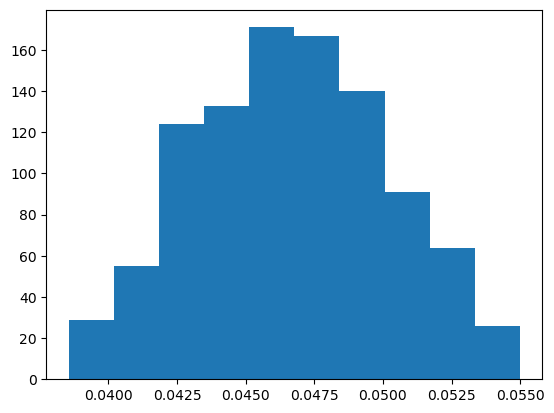

In [12]:
import matplotlib.pyplot as plt
plt.hist(lcia.score.data)

## Example 2: using nested distributions

Nested distributions are useful in situations where uncertainty exists at multiple levels. For example:

* When assessing the impact on ecosystems, there may be uncertainty about which ecosystem will be affected (e.g. forest, wetland, grassland), and also about the extent of impact within each ecosystem. In this case, we face both discrete uncertainty (which ecosystem?) and continuous uncertainty (how strongly is it affected?).

* In the context of the AWARE LCIA method, we may not know from which specific water basin the water will be abstracted (discrete choice), and there is also uncertainty regarding the characterization factor associated with each basin (continuous range).

Nested distributions allow us to model these combined uncertainties by first sampling the likely scenario (e.g. affected basin or ecosystem) and then sampling the impact value within that scenario.

This example represents a fictitious water scarcity characterization factor that incorporates both inter-basin and intra-basin uncertainty, modeled using a nested discrete_empirical distribution. It simulates a case where water abstraction could occur from one of several potential water basins, each contributing differently to water scarcity. 

With 25% probability, the water is drawn from a basin with a fixed characterization factor of 2.0. There is a 65% chance it comes from a basin whose scarcity factor is uncertain, represented by a normal distribution centered at 1.1, with a standard deviation of 0.1 and bounds between 1.0 and 1.2. Finally, there is a 10% probability of abstraction from a third basin with even more variability, captured by a triangular distribution ranging from 0.8 to 4.2 and peaking at 3.0. 

This structure allows for a nuanced representation of uncertainty: it accounts for the unknown location of the water source and for variability in the characterization factor within each basin, offering a more realistic depiction of regional water scarcity impacts.

In [19]:
{
    "name": "Some fictitious example of water scarcity with uncertainty",
    "unit": "m3 deprived-eq.",
    "version": "1.0",
    "exchanges": [
        {
           "supplier": {
              "name": "Water",
              "categories": [
                 "natural resource",
                 "in water"
              ],
             "operator": "startswith",
              "matrix": "biosphere"
           },
           "consumer": {
              "matrix": "technosphere"
           },
           "value": 1.5,
           "weight": 1.0,
           "uncertainty": {
              "distribution": "discrete_empirical",
              "parameters": {
                 "values": [
                      2.0,
                      {
                        "distribution": "normal",
                        "parameters": {
                          "loc": 1.1,
                          "scale": 0.1,
                          "minimum": 1.0,
                          "maximum": 1.2
                        }
                      },
                      {
                          "distribution": "triang",
                          "parameters": {
                          "minimum": 0.8,
                          "loc": 3.0,
                          "maximum": 4.2
                          }
                      }
                    ],
                "weights": [0.25, 0.65, 0.1],
                "negative": 0
           }
        }
      }
   ]
}

{'name': 'Some fictitious example of water scarcity with uncertainty',
 'unit': 'm3 deprived-eq.',
 'version': '1.0',
 'exchanges': [{'supplier': {'name': 'Water',
    'categories': ['natural resource', 'in water'],
    'operator': 'startswith',
    'matrix': 'biosphere'},
   'consumer': {'matrix': 'technosphere'},
   'value': 1.5,
   'weight': 1.0,
   'uncertainty': {'distribution': 'discrete_empirical',
    'parameters': {'values': [2.0,
      {'distribution': 'normal',
       'parameters': {'loc': 1.1,
        'scale': 0.1,
        'minimum': 1.0,
        'maximum': 1.2}},
      {'distribution': 'triang',
       'parameters': {'minimum': 0.8, 'loc': 3.0, 'maximum': 4.2}}],
     'weights': [0.25, 0.65, 0.1],
     'negative': 0}}}]}

In [1]:
from edges import EdgeLCIA, get_available_methods
import bw2data

In [5]:
# Select an activity from the LCA database
bw2data.projects.set_current("ecoinvent-3.10.1-cutoff")
act = bw2data.Database("ecoinvent-3.10.1-cutoff").random()
print(act)

'market for water, deionised' (kilogram, RoW, None)


In [20]:
# Initialize LCIA
lcia = EdgeLCIA(
   demand={act: 1},
   filepath="lcia_example_6.json",
   use_distributions=True,
    iterations=1000
)

# Perform inventory calculations (once)
lcia.lci()

# Map exchanges to CF entries (once)
lcia.map_exchanges()

/opt/homebrew/Caskroom/miniforge/base/envs/bw2/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 4.83e+13)
  warnings.warn(msg, UmfpackWarning)
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]

Processed edges: 5345


In [21]:
# here, the random samples are generated
lcia.evaluate_cfs()
lcia.lcia()

In [22]:
# the mean score
lcia.score.mean()

0.005098468070450652

(array([220., 165., 143., 111.,   1.,   3.,   1.,   0.,   0.,   0.,   3.,
          1.,   1.,   1.,   4.,   5., 264.,   1.,   2.,   2.,   2.,   2.,
          2.,   2.,   7.,   2.,   6.,   7.,   2.,   3.,   1.,   3.,   3.,
          3.,   1.,   3.,   1.,   6.,   3.,   1.,   0.,   0.,   1.,   5.,
          2.,   0.,   2.,   0.,   1.,   1.]),
 array([0.00341675, 0.00363027, 0.0038438 , 0.00405732, 0.00427085,
        0.00448437, 0.0046979 , 0.00491142, 0.00512495, 0.00533847,
        0.005552  , 0.00576552, 0.00597905, 0.00619257, 0.0064061 ,
        0.00661962, 0.00683315, 0.00704667, 0.0072602 , 0.00747372,
        0.00768725, 0.00790077, 0.0081143 , 0.00832782, 0.00854135,
        0.00875487, 0.0089684 , 0.00918192, 0.00939544, 0.00960897,
        0.00982249, 0.01003602, 0.01024954, 0.01046307, 0.01067659,
        0.01089012, 0.01110364, 0.01131717, 0.01153069, 0.01174422,
        0.01195774, 0.01217127, 0.01238479, 0.01259832, 0.01281184,
        0.01302537, 0.01323889, 0.01345242, 0.

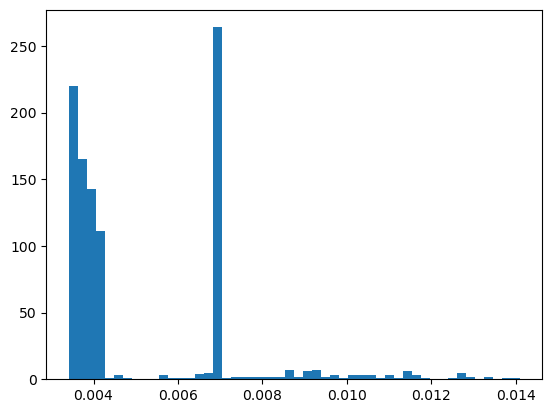

In [24]:
import matplotlib.pyplot as plt
plt.hist(lcia.score.data, bins=50)

In [14]:
lcia.statistics()

+----------------------+-----------------------------+
|       Activity       | market for water, deionised |
|     Method name      |             None            |
|         Unit         |       m3 deprived-eq.       |
|      Data file       |        lcia_example_6       |
|    CFs in method     |              1              |
|       CFs used       |              1              |
|  Exc. characterized  |             5345            |
| Exc. uncharacterized |            330564           |
+----------------------+-----------------------------+
